# The Deutsch-Josza Algorithm

For this second tutorial, we look at the Deutsch-Josza algorithm, one of the first demonstrations of the fundamental difference between quantum and classical computing.

Before anything can happen, we install the package, so that you can read while it installs.

In [33]:
%pip install qiskit[visualization] --quiet

Note: you may need to restart the kernel to use updated packages.


## Deutsch-Josza

In exercise set 4, you have seen a variation of the Deutsch-Josza problem, and it's what we're going to implement here. First, however, let us implement the simplest possible version in which the function $f$ only has a single qubit input; this is also known as the Deutsch algorithm (without Josza). 

First, let us recap the Deutsch-Josza problem. There is a function $f:\{0,1\} \to \{0,1\}$ and we want to know whether the function is constant, $f(0) = f(1)$, or if it is balanced, $f(0) \neq f(1)$.

Classically, you obviously need to call the function twice: once for $f(1)$, and once for $f(0)$. Then you compare the results, and see whether $f$ is indeed balanced or not. By now, you've seen that a quantum algorithm can get away with a single call to the function.

## The Oracle function

The main ingredient is the oracle function: a two-qubit gate $U_f$ which represents the function $f$. 

It implements it in a very specific way: if $q_0$ is the input qubit, then $U_f|q_0\rangle|q_1\rangle = |q_0\rangle|(q_1 \oplus f(q_0))\rangle$, where $\oplus$ is the bitwise addition

As a warmup, you can implement the oracle. It depends on the `is_balanced` variable. If it is true, then $q_1$ should be constant, and, if not, it should vary with $q_0$. This is implementable using standard gates.

The `mask_f` variable flips the result at random, such that we equally get cases in which the constant values can be 0 or 1, likewise for the balanced case

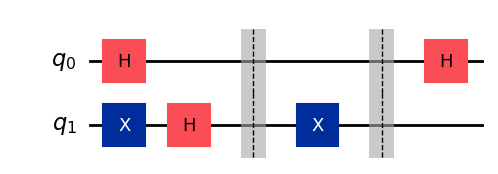

In [45]:
from qiskit import QuantumCircuit
import numpy as np

def get_oracle(is_balanced):
    oracle = QuantumCircuit(2)
    # TODO: build the oracle!
    if is_balanced:
        oracle.cx(0,1)
    else:
        ...
    
    # whether we flip the function (for completeness)
    # so whether f(0) = 1 or 0 independant of balance
    # we do this to make sure every case is accessed
    mask_f = bool(np.random.randint(0,2))
    if mask_f:
        oracle.x(1)
    return oracle


def get_deutsch_josza_circuit(oracle:QuantumCircuit)->QuantumCircuit:
    circuit = QuantumCircuit(oracle.num_qubits)
    # qubit 0 is the input
    circuit.h(0)
    circuit.x(1)
    circuit.h(1)
    # barrier is a cosmetic element
    circuit.barrier()
    circuit.compose(oracle,inplace=True)
    circuit.barrier()
    circuit.h(0)
    return circuit

# whether the function is balanced
# if no argument is given, pick random
is_balanced = bool(np.random.randint(0,2))

oracle = get_oracle(is_balanced)
circuit=get_deutsch_josza_circuit(oracle)
circuit.draw("mpl")

## Measuring 

Let's try this simple example out. We'll reuse some code from previous notebooks.

In [39]:
from qiskit.quantum_info import Statevector

# Here's our trusty circuit sampler
def sample_circuit(circuit: QuantumCircuit,n_shots:int) -> dict:
  statevector = Statevector.from_instruction(circuit)
  outcomes = statevector.sample_counts(n_shots)
  return outcomes

# and the function that print all the outcomes
def print_outcomes(outcomes:dict):
  for bitstring,counts in outcomes.items():
    print(f"Obtained bitstring |{bitstring}> {counts} times.")


Now, we can try both cases.

In [41]:
for is_balanced in (True,False):
    oracle = get_oracle(is_balanced)
    balanced_circuit = get_deutsch_josza_circuit(oracle)
    outcomes = sample_circuit(balanced_circuit,n_shots=100)
    print(f"For the {'balanced'*(is_balanced)+(1-is_balanced)*'constant'} function, we have:")
    print_outcomes(outcomes)

For the balanced function, we have:
Obtained bitstring |01> 49 times.
Obtained bitstring |11> 51 times.
For the constant function, we have:
Obtained bitstring |00> 53 times.
Obtained bitstring |10> 47 times.


As expected, $q_0$ (remember, bitstrings are right-to-left) is always 1 when the function is balanced, and always 0 when the function is constant.

Alright, now we move on to the extended version of the algorithm, which we've seen in set 4. 

First, let's reuse the code and implement the orthogonal and non-orthogonal versions of the ancilla.

In [46]:
def get_three_q_oracle(is_balanced:bool,is_orthogonal:bool)->QuantumCircuit:
    oracle = QuantumCircuit(3)
    # TODO: build the oracle again!

    if is_balanced:
        oracle.cx(0,1)
    if is_orthogonal:
        oracle.cx(0,2)

    # again, masks for completeness
    mask_f = bool(np.random.randint(0,2))
    mask_j = bool(np.random.randint(0,2))
    if mask_f:
        oracle.x(1)
    if mask_j:
        oracle.x(2)
    return oracle

We can now evaluate all four possibilities, as in the exercise. You saw that when the effect of the oracle on the second ancilla $J(q_2)$ is orthogonal, the DJ algorithm fails. Now, we may show it in an actual simulation.

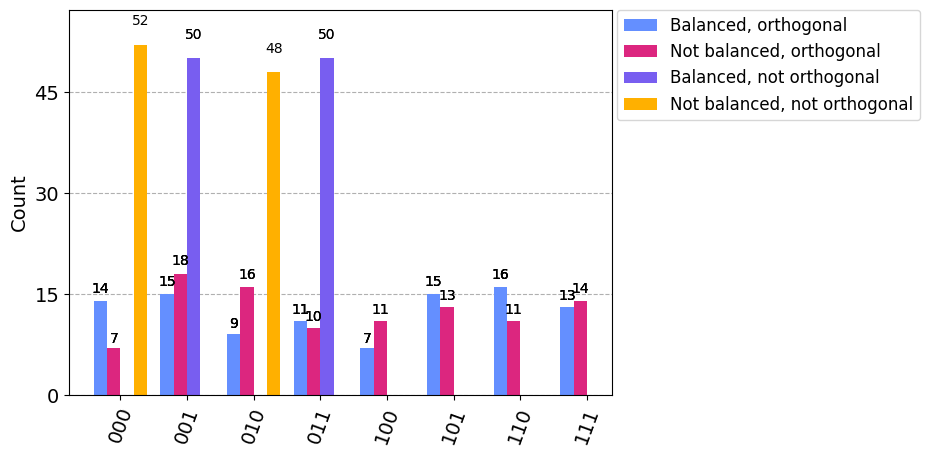

In [54]:
from qiskit.visualization import plot_histogram


result_dict={}

for is_orthogonal in (True,False):
  for is_balanced in (True,False):
    oracle = get_three_q_oracle(is_balanced,is_orthogonal)
    circuit=get_deutsch_josza_circuit(oracle)
    outcomes = sample_circuit(circuit,100)
    result_dict[f"{'Not b'*(1-is_balanced) + 'B'*is_balanced}alanced,{' not'*(1-is_orthogonal)} orthogonal"]=outcomes


plot_histogram(list(result_dict.values()),legend=list(result_dict.keys()))

As expected, and shown in the exercise, having $\langle J(q_2)|J(q_2)\rangle = 0$ causes the DJ algorithm to fail.